# Quora Question Pair Similarity

# 1. Business Problem:
<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 

__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

- Source : https://www.kaggle.com/c/quora-question-pairs

### Real world/Business Objectives and Constraints
1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

# 2. Machine Learning Problem

In [1]:
# Lets import all the necessary libraries
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Data Wrangling:

In [2]:
df = pd.read_csv('train.csv')
final_test_df = pd.read_csv('test.csv')

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


#### Data Description:
- id - the id of a training set question pair
- qid1, qid2 - unique ids of each question (only available in train.csv)
- question1, question2 - the full text of each question
- is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.
- Source: https://www.kaggle.com/c/quora-question-pairs/data

In [4]:
final_test_df.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


- As in the data descripiton, fianl test set only contains test_id, question1 and question2 features.

#### Type of Machine learning problem.

In [5]:
np.unique(df.is_duplicate)

array([0, 1])

- From above we can see that the target variable either contains 0 or 1 indication whether the question pairs are duplicate or not.
- So the machine learning problem we are trying to solve is a binary classification Problem.

#### Performance Metric:
Kaggle has given log loss as performance metric to this problem and we are taking the same log loss as a performance metric to this problem.
- Source: https://www.kaggle.com/c/quora-question-pairs/overview/evaluation

- Also we will consider binary confusion matrix to understand better. 

In [6]:
df.shape

(404290, 6)

- So there are total 404290 observations

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


- Dataset given is pretty clean except 2 null values in the the question2.
- The number of features given are also very small only 6, We may need to create features based on the data if necessary.

#### Check for Duplicates and null values:

In [8]:
df.duplicated(['qid1','qid2']).sum()

0

- So there are no duplicates

In [9]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

- So there are two null values in question2, Lets see it further

In [10]:
df.question2[df.question2.isnull()]

105780    NaN
201841    NaN
Name: question2, dtype: object

In [11]:
df.loc[105780]

id                                      105780
qid1                                    174363
qid2                                    174364
question1       How can I develop android app?
question2                                  NaN
is_duplicate                                 0
Name: 105780, dtype: object

In [12]:
df.loc[201841]

id                                        201841
qid1                                      303951
qid2                                      174364
question1       How can I create an Android app?
question2                                    NaN
is_duplicate                                   0
Name: 201841, dtype: object

In [13]:
# As we can see quesiton with id2 has null value
# Lets see how all the data related to question id2
df[df.qid2==174364]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


- As wee can see qid2 with id 174364 is present 2 times both with null values Lets drop the 2 observations from our dataframe

In [14]:
# As the 174364 qid2 has null value lets fill it with empty string.
df = df.fillna("")
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

## Exploratory Data Analysis

In [15]:
# Lets see the distribution of class variables
df.is_duplicate.value_counts(normalize=True)

0    0.630802
1    0.369198
Name: is_duplicate, dtype: float64

- So the percentage of duplicate question pairs are 63.08
- and the percentage of non duplicate question pairs are 36.91 

In [16]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [17]:
# lets see the number of unique questions
total_qids = pd.Series(df.qid1.tolist() + df.qid2.tolist())
np.unique(total_qids)

array([     1,      2,      3, ..., 537931, 537932, 537933])

In [18]:
print(f"so there are total {len(np.unique(total_qids))} unique questions present")

so there are total 537933 unique questions present


In [19]:
qs_more_than_once = np.sum(total_qids.value_counts() > 1)
print(f"questions that appeared more than once are {qs_more_than_once}")
print(f"max number of times a single question appeared is {total_qids.value_counts().max()}")

questions that appeared more than once are 111780
max number of times a single question appeared is 157


In [20]:
total_qids.value_counts().max()

157

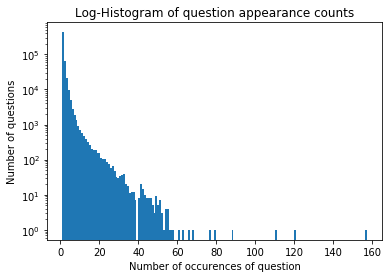

In [21]:
# Lets see the occurencess of questions
plt.hist(total_qids.value_counts(), bins=160);
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts');

plt.xlabel('Number of occurences of question');

plt.ylabel('Number of questions');

In [22]:
(total_qids.value_counts() > 1).value_counts(normalize=True)

False    0.792205
True     0.207795
dtype: float64

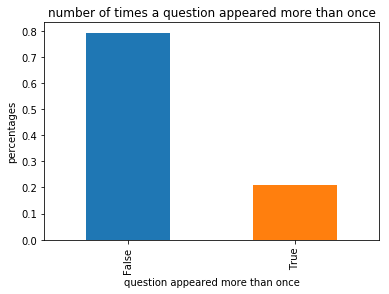

In [23]:
(total_qids.value_counts() > 1).value_counts(normalize=True).plot('bar');
plt.title("number of times a question appeared more than once");
plt.xlabel("question appeared more than once");
plt.ylabel("percentages");

- So 79.22% questions never appeared more than once
- while 20.77% questions have appeared more than once

### Preprocessing

In [24]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### We have to Clean and preprocess the text before applying any machine learning techniques

* Remove any html tags if present.
* Removing the stop words
* 

In [25]:
for ind, sent in enumerate(df.question1.values):
    if len(re.findall('<.*?>', sent)):
        print(ind, sent, '\n')

21502 Question- 30^30 - 29^30 whole divided by 30^29 + 29^29 is equal to x. Options- 1) x=1 2) x<1 3) x>1 4) cannot be determined? 

27966 Did you know <*/\*>1800*-251-*4919*-*<*/\*> Belkin router Technical support Belkin customer phone number? 

28609 “><img src=x onerror=prompt(1)> 

33357 Is this the correct way to implement a stack using an arrayList<Integer> and a queue as an arrayList<Integer> in Java? 

42742 What is the function of <head> <title>Page Title</title> </head> in HTML? 

44844 How do you make one <div> layer show over another in HTML/CSS? 

54206 Avg antivirus 1800</v\>251<’-‘>4919 Avg tech support phone number 24x7? 

59220 How can one define a constant <img> src URL in HTML, so that it can be reused in multiple attributes? 

60039 What is #include<stdio.h>? 

67100 How do I open a windows file/folders in local drive using html "<a href>" tag? 

75790 Avg antivirus 1800</v\>251<’-‘>4919 Avg tech support phone number 24x7? 

103511 What is #include<stdio.h>? 

10932

In [26]:
# Lets identify the questions related to code and exclude them when removing html tags
# Because code related questions may contain angular brackets, which may be deleted while removing html tags, makes the question useless
code_questions = [42742, 44844, 59220, 60039, 67100, 103511, 103922, 111018, 112598, 119565, 133756, 137010, 182126, 184124, 194544,\
                 197426, 209105, 258280, 266218, 272393, 335786, 344309, 345967, 350818, 362483, 380925]

In [27]:
list(df.question1.values).index('.')

3306

In [28]:
df.question1[3306]

'.'

In [29]:
df.question1[3306] = ''

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [30]:
def remove_html(array_strings):
    cleaned_q1 = []
    for ind, q1 in enumerate(array_strings):
        txt = q1
        if ind not in code_questions:
            soup = BeautifulSoup(txt, 'lxml')
            try:
                cleaned_text = soup.getText()
                cleaned_q1.append(cleaned_text)
            except:
                cleaned_q1.append(q1)
        else:
            cleaned_q1.append(q1)
    return cleaned_q1

In [31]:
%%time
cleaned_q1 = remove_html(df.question1.values)

CPU times: user 1min 47s, sys: 11.9 s, total: 1min 59s
Wall time: 3min


In [32]:
%%time 
cleaned_q2 = remove_html(df.question2.values)

CPU times: user 1min 46s, sys: 10.7 s, total: 1min 56s
Wall time: 2min 48s


In [33]:
df['cleaned_q1'] = cleaned_q1
df['cleaned_q2'] = cleaned_q2

In [34]:
stopw = set(stopwords.words('english'))
reqd_words = set(['only','very',"doesn't",'few','not'])
stopw = stopw - reqd_words

In [35]:
def series_tokenizer(pandas_series):
    final_list = []
    for sent in pandas_series.values:
        token_sent = word_tokenize(sent.lower())
        filtered_sent = [word for word in token_sent if (not word in stopw) and len(word)>1]
        final_list.append(" ".join(filtered_sent))
    return final_list

In [36]:
%%time
tokenized_q1 = series_tokenizer(df.cleaned_q1)

CPU times: user 1min 34s, sys: 144 ms, total: 1min 34s
Wall time: 1min 34s


In [37]:
%%time
tokenized_q2 = series_tokenizer(df.cleaned_q2)

CPU times: user 1min 35s, sys: 128 ms, total: 1min 35s
Wall time: 1min 35s


In [38]:
df['tokenized_q1'] = tokenized_q1
df['tokenized_q2'] = tokenized_q2

In [39]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cleaned_q1,cleaned_q2,tokenized_q1,tokenized_q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,step step guide invest share market india,step step guide invest share market
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,story kohinoor koh-i-noor diamond,would happen indian government stole kohinoor ...
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,increase speed internet connection using vpn,internet speed increased hacking dns
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,mentally very lonely solve,"find remainder math 23^ 24 /math divided 24,23"
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,one dissolve water quikly sugar salt methane c...,fish would survive salt water


In [40]:
import time

### Feature Extraction:

* cwc_min_ratio : Ratio of common word count to min(length of word count of Q1 and Q2 words)
* cwc_max_ratio : Ratio of common word count to max(length of word count of Q1 and Q2 words)
* length_diff   : abs(len(q1) - len(q2))
* fuzz_ratio    : https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
* partial_string_similarity: https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
* token_sort : https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


In [41]:
df.tokenized_q1[0], df.tokenized_q2[0]

('step step guide invest share market india',
 'step step guide invest share market')

In [47]:
from fuzzywuzzy import fuzz

In [50]:
fuzz.(df.tokenized_q1[0], df.tokenized_q2[0])

92

In [62]:
abs(np.diff((4,10)))[0]

6

In [68]:
def extracted_df(series1_list, series2_list):
    
    cwc_min = []
    cwc_max = []
    length_diff = []
    fuzz_ratio = []
    partial_string_similarity = []
    token_sort = []
    for s1, s2 in zip(series1_list, series2_list):
        string1_list = s1.split()
        string2_list = s2.split()
        num = len(np.intersect1d(string1_list, string2_list))
        lengths_tuple = (len(string1_list), len(string2_list))
        cwc_min.append(round(num/(min(lengths_tuple)+0.0001), 4))
        cwc_max.append(round(num/(max(lengths_tuple)+0.0001), 4))
        length_diff.append(abs(np.diff(lengths_tuple))[0])
        fuzz_ratio.append(fuzz.ratio(s1, s2))
        partial_string_similarity.append(fuzz.partial_ratio(s1, s2))
        token_sort.append(fuzz.token_sort_ratio(s1, s2))
    df_dict = {'cwc_min':cwc_min, 'cwc_max':cwc_max, 'length_diff':length_diff, \
               'fuzz_ratio':fuzz_ratio, 'partial_string_similarity':partial_string_similarity,\
              'token_sort':token_sort}
    
    final_df = pd.DataFrame(df_dict)
    return final_df

In [69]:
%%time
features_extracted_df = extracted_df(df.tokenized_q1.values, df.tokenized_q2.values)

CPU times: user 9min 20s, sys: 376 ms, total: 9min 20s
Wall time: 9min 20s


In [70]:
features_extracted_df.head()

,cwc_min,cwc_max,length_diff,fuzz_ratio,partial_string_similarity,token_sort
0,0.8333,0.7143,1,92,100,92
1,0.7500,0.3333,5,61,94,61
2,0.4000,0.3333,1,55,46,65
3,0.0000,0.0000,4,19,23,20
4,0.4000,0.2000,5,25,52,40


Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))


- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [76]:
final_df = pd.concat([df, features_extracted_df], axis=1)

In [77]:
final_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cleaned_q1,cleaned_q2,tokenized_q1,tokenized_q2,cwc_min,cwc_max,length_diff,fuzz_ratio,partial_string_similarity,token_sort
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,step step guide invest share market india,step step guide invest share market,0.8333,0.7143,1,92,100,92
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,story kohinoor koh-i-noor diamond,would happen indian government stole kohinoor ...,0.7500,0.3333,5,61,94,61
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,increase speed internet connection using vpn,internet speed increased hacking dns,0.4000,0.3333,1,55,46,65
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,mentally very lonely solve,"find remainder math 23^ 24 /math divided 24,23",0.0000,0.0000,4,19,23,20
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0.4000,0.2000,5,25,52,40


### Analysis of Extracted Features:

In [90]:
req_cols = features_extracted_df.columns.tolist()
req_cols.append('is_duplicate')

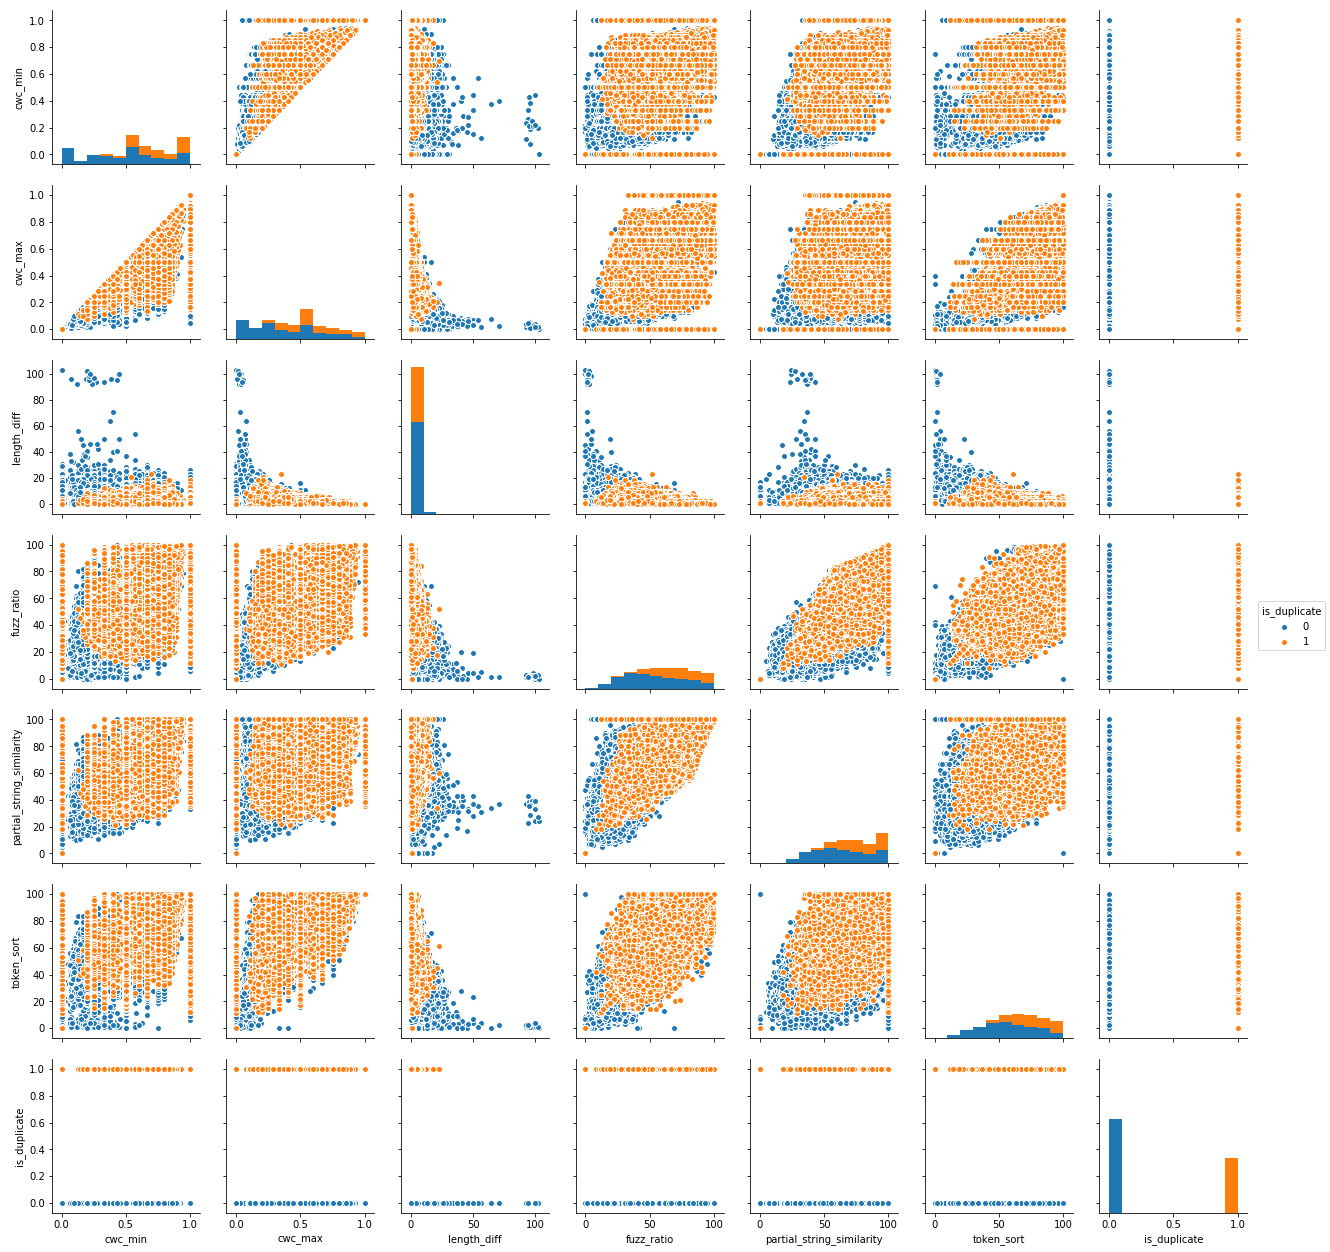

In [96]:
sns.pairplot(final_df[req_cols], hue='is_duplicate');

* From above we can clearly see that class labels are almost separable when we plot cwc_min vs cwc_max
* Also the class variables are almost separable with length difference and cwc_min 
* Above same can be seen with fuz_ratio and cwc_min and also with cwc_min and partial_string_similarity, and token_sort with cwc_min

## Lets plot the TSNE to visualize

In [97]:
from sklearn.manifold import TSNE

In [99]:
features_extracted_df.head()

,cwc_min,cwc_max,length_diff,fuzz_ratio,partial_string_similarity,token_sort
0,0.8333,0.7143,1,92,100,92
1,0.7500,0.3333,5,61,94,61
2,0.4000,0.3333,1,55,46,65
3,0.0000,0.0000,4,19,23,20
4,0.4000,0.2000,5,25,52,40


In [111]:
from sklearn.preprocessing import MinMaxScaler

In [112]:
scalled_features = MinMaxScaler().fit_transform(features_extracted_df)

In [117]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=72,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(scalled_features[:5000])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.004s...
[t-SNE] Computed neighbors for 5000 samples in 0.217s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.472s
[t-SNE] Iteration 50: error = 83.2914963, gradient norm = 0.0408494 (50 iterations in 7.587s)
[t-SNE] Iteration 100: error = 72.3564835, gradient norm = 0.0091602 (50 iterations in 6.500s)
[t-SNE] Iteration 150: error = 70.7142029, gradient norm = 0.0040726 (50 iterations in 6.466s)
[t-SNE] Iteration 200: error = 69.9513168, gradient norm = 0.0029763 (50 iterations in 6.471s)
[t-SNE] Iteration 250: error = 69.5394592, gradient norm = 0.0016929

In [118]:
tsne2d.shape

(5000, 2)

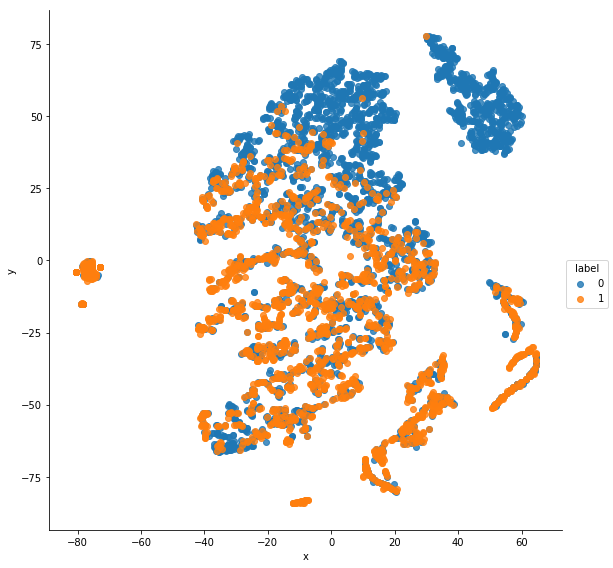

In [121]:
tsne_df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1], 'label':df.is_duplicate[:5000]})
sns.lmplot(data=tsne_df, x='x', y='y', hue='label', fit_reg=False, size=8);

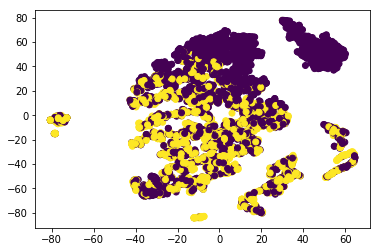

In [119]:
plt.scatter(tsne2d[:,0], tsne2d[:,1], c=df.is_duplicate[:5000]);

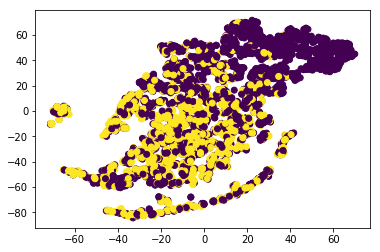

In [108]:
plt.scatter(tsne2d[:,0], tsne2d[:,1], c=df.is_duplicate[:5000]);

In [122]:
from wordcloud import WordCloud

In [130]:
duplicate_q1_string = ' '.join(df.tokenized_q1[final_df.is_duplicate==1].values)
duplicate_q2_string = ' '.join(df.tokenized_q2[final_df.is_duplicate==1].values)
non_duplicate_q1_string = ' '.join(df.tokenized_q1[final_df.is_duplicate==0].values)
non_duplicate_q2_string = ' '.join(df.tokenized_q2[final_df.is_duplicate==0].values)

In [133]:
duplicate_string = duplicate_q1_string + ' ' + duplicate_q2_string
non_duplicate_string = non_duplicate_q1_string + ' ' + non_duplicate_q2_string

Word Cloud for Duplicate Question pairs


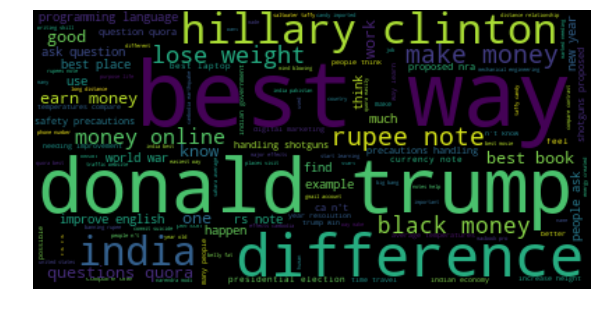

In [137]:
wc = WordCloud()
wc.generate(duplicate_string)
print ("Word Cloud for Duplicate Question pairs")
plt.figure(figsize = (10, 20), facecolor = None)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non Duplicate Question pairs


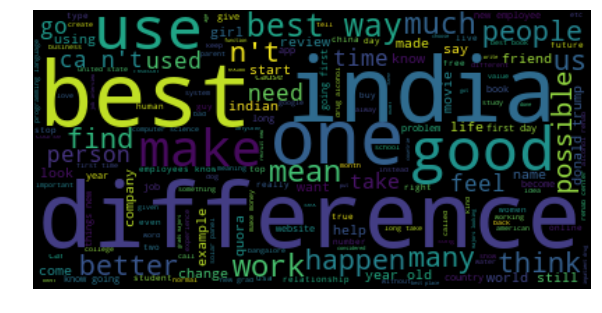

In [139]:
wc = WordCloud()
wc.generate(non_duplicate_string)
print ("Word Cloud for non Duplicate Question pairs")
plt.figure(figsize = (10, 20), facecolor = None)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()